# Quantile based global sensitivity measures 


New global sensitivity measures based on quantiles of the output has been introduced by [Kucherenko et al.(2019)](https://www.sciencedirect.com/science/article/abs/pii/S0951832016304574) in which $\alpha$th quantiles are the functions of interest.
This notebook reproduces the numerical test results of the paper. Equation numbers and notations below are coincide
to the paper.


To do:
- Add sobol indices into plots
- Fix sampling error in Test 4
  

In [124]:
import numpy as np
import chaospy as cp
import matplotlib.pyplot as plt
from scipy.stats import norm,uniform,expon

from kucherenko import kucherenko_indices

# Analytical results for test 1(Section 6 & 7)

For **linear model with normally distributed variables**, analytical values of sensitivity indices can be found and used as benchmarks for verification of numerical estimates. 

### Parameters

In [200]:
# mean and covariance
mean_1 = np.array([1, 3, 5, 7])
cov_1 = np.array(
    [
        [1, 0, 0, 0],
        [0, 2.25, 0, 0],
        [0, 0, 4, 0],
        [0, 0, 0, 6.25],
    ],
)

# dimension 
dim = 4

# range of alpha
dalp = (0.98 - 0.02) / 30   # 0.032
alp = np.arange(0.02, 0.98 + dalp, dalp) 

### Objective function
$$Y=x_1+x_2+x_3+x_4$$

In [201]:
# objective function (Eq.32)
a = np.array([1, 1, 1, 1])

def objfun(x):
    result = a[0] * x[:, 0] + a[1] * x[:, 1] + a[2] * x[:, 2] + a[3] * x[:, 3]
    return result

### sobol indices

$$
S_i=S_i^{tot}=\frac{a_i^2 \sigma_i^2}{\sum_{j=1}^d a_j^2 \sigma_j^2}
$$

In [202]:
# sobol indices
S_i = []
for i in range(dim):
    S_i_i = a[0] ** 2 * cov_1[i, i] / np.trace(np.power(a, 2) * cov_1)
    S_i.append(S_i_i)

S_i = np.hstack(S_i)

print(S_i)

# for plot convinence
S_i = np.tile(S_i, (len(alp), 1))

[0.07407407 0.16666667 0.2962963  0.46296296]


### Quantile-based measures
$q_i^{(2)}(\alpha)$ of linear model with normally distributed variables is obtained from following formula:

$$
q_i^{(2)}(\alpha)=a_i^2 \sigma_i^2+[\Phi^{-1}(\alpha)]^2 \left(\sqrt{\sum_{i=1}^d a_i^2 \sigma_i^2}-\sqrt{\sum_{j=1,j \ne i}^d a_j^2 \sigma_j^2} \right)^2
\tag{30}
$$

In [203]:
# inverse error function
phi_inv = norm.ppf(alp)

# q_2: PDF of the out put Y(Eq.30)
q_2 = []
for a in range(len(alp)):
    q_2_a = []
    for i in range(dim):
        q_2_i = cov_1[i,i] + phi_inv[a] ** 2 * (np.sqrt(np.trace(cov_1)) - np.sqrt(sum(cov_1[j, j] for j in range(dim) if j != i))) ** 2
        q_2_a.append(q_2_i)
    q_2.append(q_2_a)
    
q_2 = np.vstack(q_2).reshape((len(alp), dim))

In [204]:
# Q_2: normalized quantile based sensitivity measure 2.(Eq.14)
Q_2 = []
for a in range(len(alp)):
    Q_2_a = []
    for i in range(dim):
        Q_2_i = q_2[a, i] / sum(q_2[a])
        Q_2_a.append(Q_2_i)
    Q_2.append(Q_2_a)

Q_2 = np.hstack(Q_2).reshape((len(alp), dim))

### Plot

Text(0, 0.5, 'Measures')

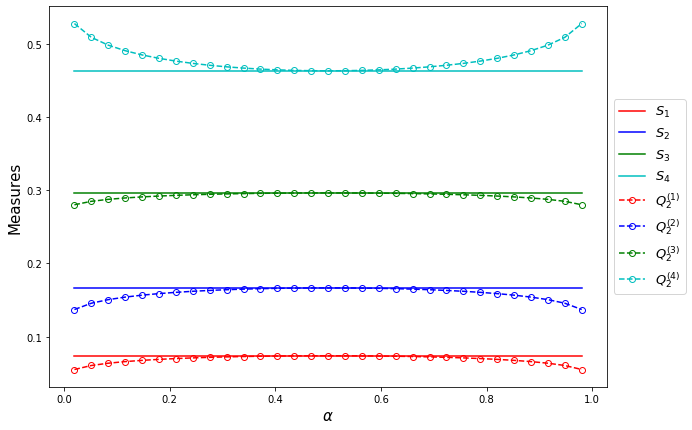

In [205]:
plt.figure(figsize=(10,7))

plt.plot(alp, S_i[:, 0], 'r-', label=r'$S_1$')
plt.plot(alp, S_i[:, 1], 'b-', label=r'$S_2$')
plt.plot(alp, S_i[:, 2], 'g-', label=r'$S_3$')
plt.plot(alp, S_i[:, 3], 'c-', label=r'$S_4$')

plt.plot(alp, Q_2[:, 0], 'ro--',label=r'$Q_2^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q_2[:, 1], 'bo--',label=r'$Q_2^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q_2[:, 2], 'go--',label=r'$Q_2^{(3)}$', markerfacecolor='none')
plt.plot(alp, Q_2[:, 3], 'co--',label=r'$Q_2^{(4)}$', markerfacecolor='none')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel("Measures", fontsize=15)

# DLR MC estimator(section 4 & 7)

## Steps

### Step 1: Sampling   

1. Generate $N$ points $x^{(j)},j=1,2, \dots, N$ from the joint PDF $\rho(x_1, \dots, x_d)$
    1. Generate N points of n-dimensional **uniform distributed** sample
    1. Transform uniform draw into a **standard normal** draw
    1. Transform standard normal draw into assigned joint PDF $\rho(x_1, \dots, x_d)$

1. Construct conditional sample: 
    1. Sort base sample set $x^{(j)},j=1,2, \dots, N$ in ascending order with respect to the values of $x_i$ and subdivided in **M equally populated partitions (bins)** with $N_m=N/M$ points in each bin $(M < N)$
    1. Within each bin a mixed $\{(x_{\sim i}^j,x_{i}^{'(j)})\}$ set distributed according to a conditional PDF $\rho(x_1, \dots, x_d|x_i=X_i^{'(j)})$  where $(x_{\sim i}^j,x_i^{'(j)})=(x_1^j, \dots, x_i^{'(j)}, \dots, x_d^j)$ 

###  Step 2: Build a CDF  of output 

1. CDF **$F_Y(y)$** of the out put $Y$
$$
F_Y^{(N)}(y)=\frac{1}{N} \sum_{l=1}^N I(Y(x_1^l, \dots , x_d^l)<y)
\tag{21a}
$$
1. Within each bin the CDF **$F_{Y|x_i}(y)$** of the output conditional on the input variable $x_i$ being fixed at $x_i=X_i^l,l=1,\dots, N_m$ is estimated as
$$
F_{Y \mid X_i}^{(N_m)}(y)=\frac{1}{N_m} \sum_{l=1}^{N_m} I(Y(x_1^l, \dots , x_i^l = X_i^l, \dots , x_d^l)<y)
\tag{26}
$$

###  Step 3: Get quantiles of output

1. Unconditional quantile 
    $$
    q_Y^{(N)}(\alpha)=[F_Y^{(N)}]^{-1}(\alpha)=\inf 	\left\{ y \mid F_Y^{(N)}(Y \le y) \ge \alpha \right\}
    \tag{22}
    $$
1. Conditional quantile 
    $$
    q_{Y \mid X_i}^{(N)}(\alpha)=[F_{Y \mid X_i}^{(N)}]^{-1}(\alpha)=\inf 	\left\{ y \mid F_{Y \mid X_i}^{(N)}(Y \le y \mid x_i=X_i) \ge \alpha \right\}
    \tag{23}
    $$

### Step 4: MC/QMC estimates of quantiles

1. Quantile based measures
    $$
\tilde{q_i}^{(1)}(\alpha)=\frac{1}{M} \sum_{j=1}^M \mid q_Y^{(N_m)}(\alpha)-q_{Y \mid X_i^{j}}^{(N_m)}(\alpha) \mid
    \tag{27}
    $$

    $$
\tilde{q_i}^{(2)}(\alpha)=\frac{1}{M} \sum_{j=1}^M \left( q_Y^{(N_m)}(\alpha)-q_{Y \mid X_i^{j}}^{(N_m)}(\alpha) \right)^2
    \tag{28}
    $$
1. Nomalized quantile based measures
$$
Q_i^{(1)}(\alpha)=\frac{\bar{q}_i^{(1)}(\alpha)}{\sum_{j=1}^d \bar{q}_j^{(1)}(\alpha)}
\tag{13}
$$   

$$
Q_i^{(2)}(\alpha)=\frac{\bar{q}_i^{(2)}(\alpha)}{\sum_{j=1}^d \bar{q}_j^{(2)}(\alpha)}
\tag{14}
$$



## MCS_quantile function

In [206]:
# Total number of sample points
N = 2**13 # 8192

# number of conditional samples
M = 64

In [ ]:
def _get_unconditional_sample(N, M, loc, scale, dim, skip, dist_type):
    # Generate uniform distributed sample
    A = np.zeros((N,dim)) 
    X001 = cp.generate_samples(order=N+skip, domain=dim, rule="S").T
    X01 = X001[skip:, :dim]
    
    # Transform uniform draw into into assigned joint PDF 
    if dist_type == "Normal":
        X1 = norm.ppf(X01)
        cholesky = np.linalg.cholesky(scale)
        A = loc + cholesky.dot(X1.T).T
    elif dist_type == "Exponential":
        A = expon.ppf(X01,loc,scale)
    elif dist_type == "Uniform":
        A = uniform.ppf(X01,loc,scale)
    else:
        raise NotImplementedError

    return A

In [259]:
def MCS_quantile(objfun, A, N, M, dim):
    """Compute Monte Carlo estimates of quantile based global sensitivity measures.
    
    This function implements the Monte Carlo Double Loop Reordering approach describe in
    [Section 4] of Kucherenko et al.(2019).

    Parameters
    ----------
    objfun: callable 
        Objective function to implement the quantile based measures. Must be broadcastable.

    N: int 
        Number of sampled points. This will later turn into the number of Monte Carlo draws. 
        To preserve their uniformity properties N should always be equal to N = 2p, where p 
        is an integer.      

    M: int
        Number of conditional samples.

    dim: int 
        Dimension of inputs for objective function.

    loc: np.ndarray or float
        Shift of “standardized” distribution. For multivariate normal distribution the 
        'loc' specifies the mean.
        
    scale: np.ndarray or float
        Scale of “standardized” distribution. For multivariate normal distribution the 
        'scale' specifies the Covariance matrix. 

    skip: int
        Number of values to skip for generating Sobol sequence.

    dist_type: str 
        The distribution type of input. Options are "Normal", "Exponential" and "Uniform".

    Returns
    -------
    q1_alp: np.ndarray
        Quantile based measure.
        
    q2_alp: np.ndarray
        Quantile based measure.
        
    Q1_alp: np.ndarray
        Nomalized quantile based measure.
        
    Q2_alp: np.ndarray 
        Nomalized quantile based measure.
    """
    # Get quantile based measure
    q1_alp, q2_alp = _quantile_based_measures(objfun, A, N, M, dim, alp)
    
    # Get nomalizeduantile based measure
    Q1_alp, Q2_alp = _nomalized_quantile_based_measures(objfun, A, N, M, dim)
    
    return q1_alp, q2_alp, Q1_alp, Q2_alp


####Step 1: Sampling
# def _get_unconditional_sample(N, M, loc, scale, dim, skip, dist_type):
#     # Generate uniform distributed sample
#     A = np.zeros((N,dim)) 
#     X001 = cp.generate_samples(order=N+skip, domain=dim, rule="S").T
#     X01 = X001[skip:, :dim]
    
#     # Transform uniform draw into into assigned joint PDF 
#     if dist_type == "Normal":
#         X1 = norm.ppf(X01)
#         cholesky = np.linalg.cholesky(scale)
#         A = loc + cholesky.dot(X1.T).T
#     elif dist_type == "Exponential":
#         A = expon.ppf(X01,loc,scale)
#     elif dist_type == "Uniform":
#         A = uniform.ppf(X01,loc,scale)
#     else:
#         raise NotImplementedError

#     return A


def _get_conditional_sample(A, N, M, dim):
    # conditional sample matrix C,with shape the of (64, 4, 8192, 4)
    B = A[:M]
    C = np.array([[np.zeros((N,dim)) for x in range(dim)] for z in range(M)],dtype=np.float64)  
    for i in range(dim):
        for j in range(M):
            C[j,i] = A
            C[j,i,:,i] = B[j, i]   
    
    return C


####Step 2 & 3: Build CDF and quantiles of output
def _unconditional_q_Y(objfun, A, N, M, dim, alp):
    # values of outputs
    Y1 = objfun(A)
    # reorder in ascending order
    y1 = np.sort(Y1)
    
    # q_Y(alp)
    q_index = (np.floor(alp * N) - 1).astype(int)
    qy_alp1 = y1[q_index]
    
    return qy_alp1 


def _conditional_q_Y(objfun, A, N, M, dim, alp):
    C  = _get_conditional_sample(A, N, M, dim) # shape(64, 4, 8192, 4)

    # initialize values of conditional outputs.
    Y2 = np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64) # shape(8192, 4, 8192, 1)
    y2 = np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
    
    # initialize quantile of conditional outputs.
    qy_alp2 = np.array([[np.zeros((len(alp),M)) for x in range(dim)] for z in range(1)],dtype=np.float64) # shape(1, 4, 31, 64)
    
    for i in range(dim):
        for j in range(M):
            Y2[j, i] = np.vstack(objfun(C[j, i]))  # values of conditional outputs
            Y2[j, i].sort(axis=0) # reorder in ascending order
            y2[j, i] = Y2[j, i] 
            for pp in range(len(alp)):
                qy_alp2[0, i, pp, j] = y2[j, i][(np.floor(alp[pp] * N) - 1).astype(int)] # conditioanl q_Y(alp)
    
    return qy_alp2

####Step 4: MC/QMC estimates of quantiles
def _quantile_based_measures(objfun, A, N, M, dim, alp):
    
    qy_alp1 = _unconditional_q_Y(objfun, A, N, M, dim, alp)
    qy_alp2 = _conditional_q_Y(objfun, A, N, M, dim, alp)
    
    # initialization
    q1_alp=np.zeros((len(alp), dim))
    q2_alp=np.zeros((len(alp), dim))
    delt=np.array([[np.zeros((1, M)) for x in range(dim)] for z in range(1)], dtype=np.float64)
    
    for i in range(dim):
        for pp in range(len(alp)):
            delt[0, i] = qy_alp2[0, i, pp, :] - qy_alp1[pp]  # delt
            q1_alp[pp, i] = np.mean(np.absolute(delt[0, i]))  # |delt|
            q2_alp[pp, i] = np.mean(delt[0, i] ** 2)  # (delt)^2
            
    return q1_alp, q2_alp


def _nomalized_quantile_based_measures(objfun, A, N, M, dim):
    # range of alpha
    dalp = (0.98 - 0.02) / 30   # 0.032
    alp = np.arange(0.02, 0.98 + dalp, dalp) 
    
    q1_alp, q2_alp = _quantile_based_measures(objfun, A, N, M, dim, alp)
    
    # initialize quantile measures arrays. 
    q1 = np.zeros(len(alp)) # shape (1, 31)
    q2 = np.zeros(len(alp))
    Q1_alp = np.zeros((len(alp), dim))
    Q2_alp = np.zeros((len(alp), dim))
 
    for pp in range(len(alp)):
        q1[pp] = np.sum(q1_alp[pp, :])
        q2[pp] = np.sum(q2_alp[pp, :])
        for i in range(dim):
            Q1_alp[pp, i] = q1_alp[pp, i] / q1[pp]
            Q2_alp[pp, i] = q2_alp[pp, i] / q2[pp]
    
    return Q1_alp, Q2_alp

## Numerical tests

### Test 1: independent inputs
   $Y=a_1x_1+a_2x_2+a_3x_3+a_4x_4$, where $x_i \sim N(\mu_i,\sigma^2)$ 

#### Objective function

In [ ]:
# objective function
a = [1, 1, 1, 1]
def objfun1(x):
    result = a[0] * x[:, 0] +a [1] * x[:, 1] + a[2] * x[:, 2] + a[3] * x[:, 3]
    return result

#### Parameters

In [264]:
# mean for normal distribution
miu_1 = np.array([1, 3, 5, 7])

# standard deviation for normal distribution
cov_1 = np.array(
    [
        [1, 0, 0, 0],
        [0, 2.25, 0, 0],
        [0, 0, 4, 0],
        [0, 0, 0, 6.25],
    ],
)

sd = np.sqrt(np.diag(cov_1))

# dimension of inpußts
dim = np.size(miu_1) # 4

#### Build base sample

In [261]:
# Generate uniform distributed sample
A_1 = np.zeros((N,dim)) 
skip = 0
X01 = cp.generate_samples(order=N+skip, domain=dim, rule="S").T
X01 = X01[skip:, :dim]
    
# Transform uniform draw into into normal
A_1 = norm.ppf(X01, loc=miu_1, scale=sd)

#### Get measures

In [262]:
q1_alp, q2_alp, Q1_alp, Q2_alp = MCS_quantile(objfun1, A, N, M, dim)

In [265]:
# get sobol indice from the kucherenko_indices function wriiten by Tim
sobol_indices = kucherenko_indices(func=objfun1, sampling_mean=miu_1, sampling_cov=cov_1, n_draws=N,)
S_i_1 = np.hstack(sobol_indices[sobol_indices.index.get_level_values('type')=='first_order'].values)

print(S_i_1)

# for plot convinence
S_i_1 = np.tile(S_i_1, (len(alp), 1))

[0.07051515 0.16374846 0.29401241 0.46122699]


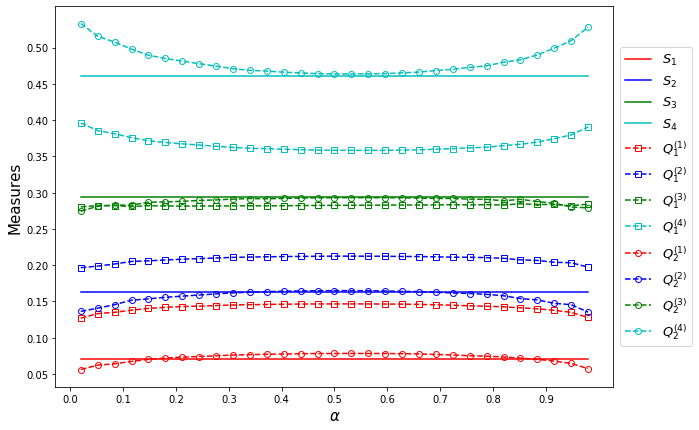

In [266]:
plt.figure(figsize=(10,7))

plt.plot(alp, S_i_1[:, 0], 'r-', label=r'$S_1$')
plt.plot(alp, S_i_1[:, 1], 'b-', label=r'$S_2$')
plt.plot(alp, S_i_1[:, 2], 'g-', label=r'$S_3$')
plt.plot(alp, S_i_1[:, 3], 'c-', label=r'$S_4$')

plt.plot(alp,  Q1_alp[:, 0], 'rs--', label=r'$Q_1^{(1)}$', markerfacecolor='none')
plt.plot(alp,  Q1_alp[:, 1], 'bs--', label=r'$Q_1^{(2)}$', markerfacecolor='none')
plt.plot(alp,  Q1_alp[:, 2], 'gs--', label=r'$Q_1^{(3)}$', markerfacecolor='none')
plt.plot(alp,  Q1_alp[:, 3], 'cs--', label=r'$Q_1^{(4)}$', markerfacecolor='none')

plt.plot(alp, Q2_alp[:, 0], 'ro--', label=r'$Q_2^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 1], 'bo--', label=r'$Q_2^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 2], 'go--', label=r'$Q_2^{(3)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 3], 'co--', label=r'$Q_2^{(4)}$', markerfacecolor='none')

plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0.05, 0.55, 0.05))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=13)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel("Measures", fontsize=15)

plt.show()

### Test 2:  independent inputs
$Y=x_1-x_2+x_3-x_4$, where $x_i \sim Exp(\lambda=1)$


#### Objective function

In [273]:
# objective function
a = [1,-1,1,-1]
def objfun2(x):
    result = a[0] * x[:, 0] + a[1] * x[:, 1] + a[2] * x[:, 2] + a[3] * x[:, 3]
    return result

#### Parameters

In [274]:
# dimension of inputs
dim = np.size(a) # 4

#### Build base sample

In [281]:
# Generate uniform distributed sample
A_2 = np.zeros((N,dim)) 
skip = 0
X02 = cp.generate_samples(order=N+skip, domain=dim, rule="S").T
X02 = X02[skip:, :dim]
    
# Transform uniform draw into exponential draw
A = expon.ppf(X02)

#### Get measures

In [278]:
q1_alp, q2_alp, Q1_alp, Q2_alp = MCS_quantile(objfun1, A, N, M, dim)

In [279]:
# get sobol indice from the kucherenko_indices function wriiten by Tim
sobol_indices = kucherenko_indices(func=objfun2, sampling_mean=miu_1, sampling_cov=cov_1, n_draws=N,)
S_i_1 = np.hstack(df_indices[df_indices.index.get_level_values('type')=='first_order'].values)

print(S_i_1)

# for plot convinence
S_i_1 = np.tile(S_i_1, (len(alp), 1))

[0.07051515 0.16374846 0.29401241 0.46122699]


Text(0, 0.5, 'Measures')

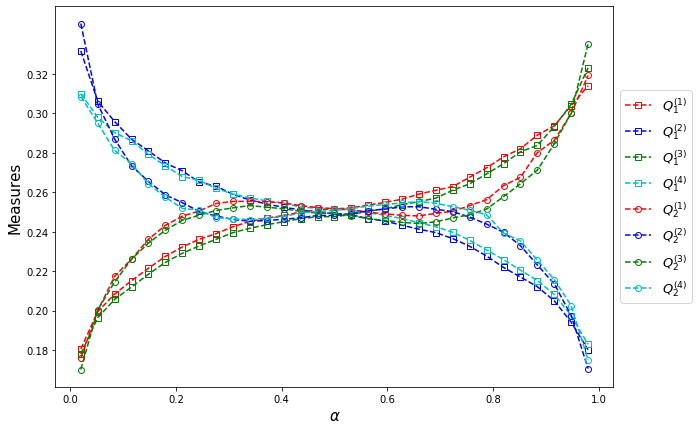

In [286]:
plt.figure(figsize=(10,7))

# plt.plot(alp, S_i_plot[:, 0], 'r-', label=r'$S_1$')
# plt.plot(alp, S_i_plot[:, 1], 'b-', label=r'$S_2$')
# plt.plot(alp, S_i_plot[:, 2], 'g-', label=r'$S_3$')
# plt.plot(alp, S_i_plot[:, 3], 'c-', label=r'$S_4$')

plt.plot(alp,  Q1_alp[:, 0], 'rs--',label=r'$Q_1^{(1)}$', markerfacecolor='none')
plt.plot(alp,  Q1_alp[:, 1], 'bs--',label=r'$Q_1^{(2)}$', markerfacecolor='none')
plt.plot(alp,  Q1_alp[:, 2], 'gs--',label=r'$Q_1^{(3)}$', markerfacecolor='none')
plt.plot(alp,  Q1_alp[:, 3], 'cs--',label=r'$Q_1^{(4)}$', markerfacecolor='none')

plt.plot(alp, Q2_alp[:, 0], 'ro--',label=r'$Q_2^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 1], 'bo--',label=r'$Q_2^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 2], 'go--',label=r'$Q_2^{(3)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 3], 'co--',label=r'$Q_2^{(4)}$', markerfacecolor='none')

plt.yticks(np.arange(0.18, 0.32, 0.02))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel("Measures", fontsize=15)

### Test 3:  independent inputs
$Y=sin(x_1)+7(sin x_2)^2+0.1x_3^4sin(x_1)$, where $x_i$ uniform distributed on the interval$[-\pi,\pi]$

In [106]:
# objective function
def objfun3(x):
    result = np.sin(x[:, 0]) + 7 * np.sin(x[:, 1]) ** 2 + 0.1 * x[:, 2] ** 4 * np.sin(x[:, 0]) 
    return result

# dimension of inputs
dim = 3 

# distribution type
dist_type = "Uniform"

skip = 0

# lower bound of uniform distribution
lower_bound = -np.pi
# interval of uniform distribution
interval = 2 * np.pi


In [107]:
q1_alp, q2_alp, Q1_alp, Q2_alp = MCS_quantile(objfun3, N, M, dim, lower_bound, interval, skip, dist_type)

Text(0, 0.5, 'Measures')

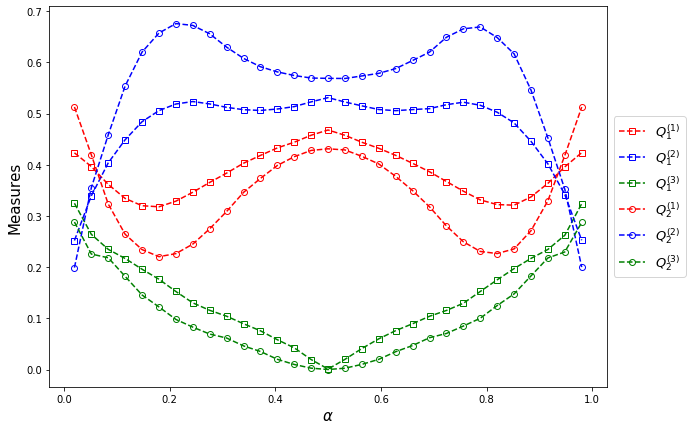

In [109]:
plt.figure(figsize=(10, 7))

plt.plot(alp, Q1_alp[:, 0], 'rs--',label=r'$Q_1^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp[:, 1], 'bs--',label=r'$Q_1^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp[:, 2], 'gs--',label=r'$Q_1^{(3)}$', markerfacecolor='none')


plt.plot(alp, Q2_alp[:, 0], 'ro--',label=r'$Q_2^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 1], 'bo--',label=r'$Q_2^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 2], 'go--',label=r'$Q_2^{(3)}$', markerfacecolor='none')

plt.yticks(np.arange(0.05, 0.55, 0.05))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel("Measures", fontsize=15)

### Test 4: correlated inputs
$Y=x_1 x_3+x_2 x_4$, where$(x_1,x_2,x_3,x_4) \sim N(\mu, \Sigma_x)$ 

In [231]:
miu_4 = np.array([0, 0, 250, 400])

cov_4 = np.array(
    [
        [16, 2.4, 0, 0],
        [2.4, 4, 0, 0],
        [0, 0, 40000, -18000],
        [0, 0, -18000, 90000],
    ],
)

def objfun4(x):
    result = x[:, 0] * x[:, 2] + x[:, 1] * x[:, 3]
    return result


# dimension of inputs
dim = np.size(miu)

# distribution type
dist_type = "Normal"
skip = 0

In [232]:
q1_alp, q2_alp, Q1_alp, Q2_alp = MCS_quantile(objfun4, N, M, dim, miu_4 ,cov_4, skip, dist_type)

In [236]:
# get sobol indice from the kucherenko_indices function wriiten by Tim
sobol_indices = kucherenko_indices(func=objfun4, sampling_mean=miu_4, sampling_cov=cov_4, n_draws=N,)
S_i_4 = np.hstack(sobol_indices[sobol_indices.index.get_level_values('type')=='first_order'].values)

print(S_i_4)

# for plot convinence
S_i_4 = np.tile(S_i_4, (len(alp), 1))

[ 0.5060065   0.39992348 -0.00167656 -0.00133196]


Text(0, 0.5, 'Measures')

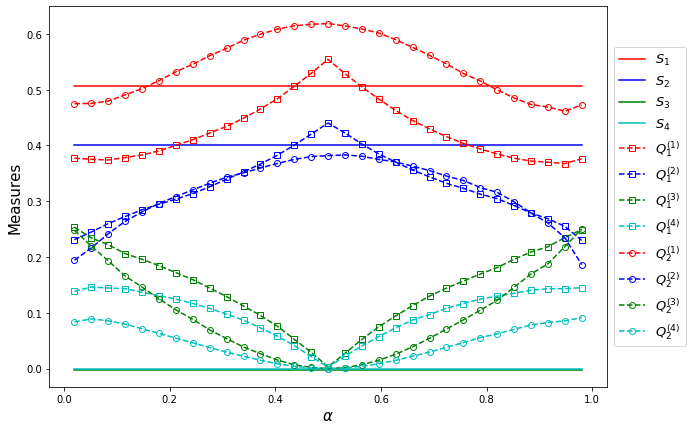

In [237]:
plt.figure(figsize=(10, 7))

plt.plot(alp, S_i_4[:, 0], 'r-', label=r'$S_1$')
plt.plot(alp, S_i_4[:, 1], 'b-', label=r'$S_2$')
plt.plot(alp, S_i_4[:, 2], 'g-', label=r'$S_3$')
plt.plot(alp, S_i_4[:, 3], 'c-', label=r'$S_4$')

plt.plot(alp, Q1_alp[:, 0], 'rs--', label=r'$Q_1^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp[:, 1], 'bs--', label=r'$Q_1^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp[:, 2], 'gs--', label=r'$Q_1^{(3)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp[:, 3], 'cs--', label=r'$Q_1^{(4)}$', markerfacecolor='none')

plt.plot(alp, Q2_alp[:, 0], 'ro--', label=r'$Q_2^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 1], 'bo--', label=r'$Q_2^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 2], 'go--', label=r'$Q_2^{(3)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 3], 'co--', label=r'$Q_2^{(4)}$', markerfacecolor='none')

plt.yticks(np.arange(0.05, 0.55, 0.05))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel("Measures", fontsize=15)

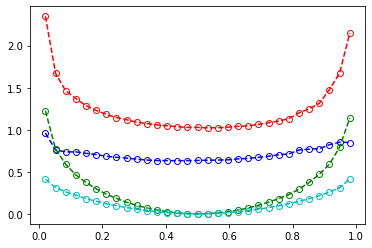

In [117]:
plt.plot(alp, q2_alp[:, 0]/1000000, 'ro--', label=r'$q_2^{(1)}$', markerfacecolor='none')
plt.plot(alp, q2_alp[:, 1]/1000000, 'bo--', label=r'$q_2^{(2)}$', markerfacecolor='none')
plt.plot(alp, q2_alp[:, 2]/1000000, 'go--', label=r'$q_2^{(3)}$', markerfacecolor='none')
plt.plot(alp, q2_alp[:, 3]/1000000, 'co--', label=r'$q_2^{(4)}$', markerfacecolor='none')

## Practical case study : Roof Truss structure(Section 8)

In [227]:
loc = np.array([20000, 12, 9.82 * 10 ** (-4), 0.04, 2 * 10**11,3*10**10])
scale = np.array([1400,0.12,5.89*10**(-5),0.0048,1.2*10**10,1.8*10**9])

dist_type = "Uniform"
dim=6

In [228]:
def objfun5(x):
    result = 0.03-(x[:,0]*x[:,1]**2/2*(3.81/(x[:,3]*x[:,5])+1.13/(x[:,2]*x[:,4])))
    return result


In [229]:
q1_alp, q2_alp, Q1_alp, Q2_alp = MCS_quantile(objfun5, N, M, dim, loc ,scale, 0, dist_type)

Text(0, 0.5, 'Measures')

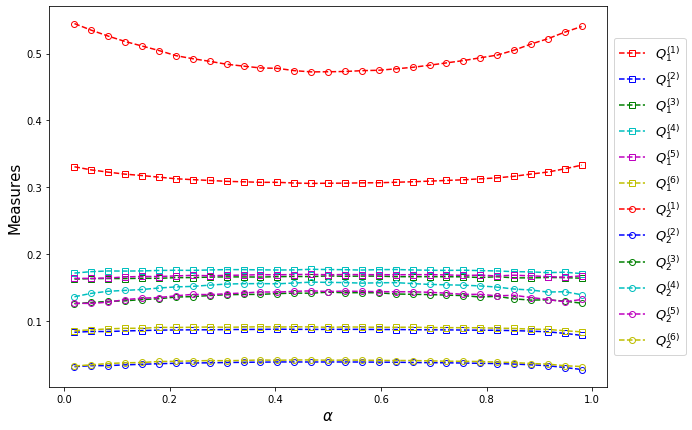

In [230]:
plt.figure(figsize=(10, 7))

plt.plot(alp, Q1_alp[:, 0], 'rs--', label=r'$Q_1^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp[:, 1], 'bs--', label=r'$Q_1^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp[:, 2], 'gs--', label=r'$Q_1^{(3)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp[:, 3], 'cs--', label=r'$Q_1^{(4)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp[:, 4], 'ms--', label=r'$Q_1^{(5)}$', markerfacecolor='none')
plt.plot(alp, Q1_alp[:, 5], 'ys--', label=r'$Q_1^{(6)}$', markerfacecolor='none')

plt.plot(alp, Q2_alp[:, 0], 'ro--', label=r'$Q_2^{(1)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 1], 'bo--', label=r'$Q_2^{(2)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 2], 'go--', label=r'$Q_2^{(3)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 3], 'co--', label=r'$Q_2^{(4)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 4], 'mo--', label=r'$Q_2^{(5)}$', markerfacecolor='none')
plt.plot(alp, Q2_alp[:, 5], 'yo--', label=r'$Q_2^{(6)}$', markerfacecolor='none')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel("Measures", fontsize=15)